In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
boston = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')

In [4]:
boston.head(2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per $10,000
PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in $1000's

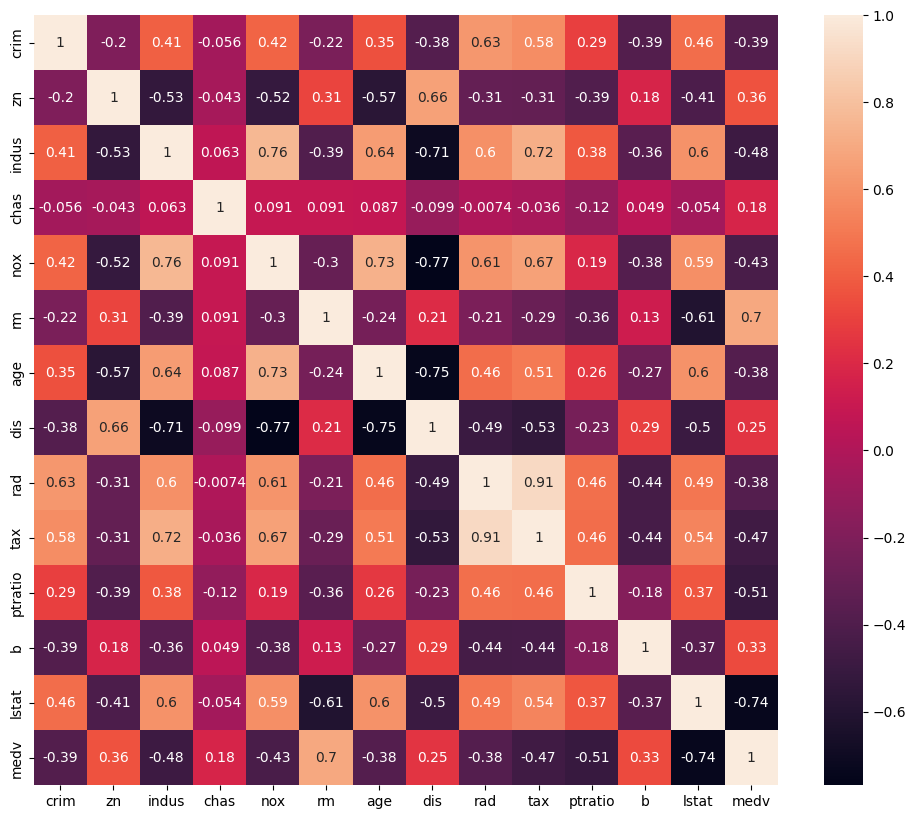

In [14]:
corr_mat = boston.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_mat, annot=True)
plt.show()

Based on the correlation matrix, identify highly correlated features. A commonly used threshold is a correlation coefficient greater than or equal 0.8 or less than or equal -0.8.

Remove highly correlated features.

In [27]:
threshold = 0.8

high_corr = np.where(np.abs(corr_mat.values[:-1,:-1]) >= threshold)
#high_corr = np.where(np.abs(corr_mat.values) >= threshold)

features_to_remove = set()

for i,j in zip(*high_corr):
  if(i != j ) and (i not in features_to_remove) and (j not in features_to_remove):
    features_to_remove.add(j if np.abs(corr_mat['medv']).iloc[i] > np.abs(corr_mat['medv']).iloc[j] else i)

df_filtered_corr = boston.drop(boston.columns[list(features_to_remove)],axis=1)
df_filtered_corr

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,273,21.0,393.45,6.48,22.0


#### VIF Approach

In [29]:
!pip install statsmodels

In [49]:
#Calculating VIF for all features
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = boston.drop(columns='medv',axis=1)

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

vif

,Features,VIF
0,crim,2.100373
1,zn,2.844013
2,indus,14.485758
3,chas,1.152952
4,nox,73.894947
5,rm,77.948283
6,age,21.386850
7,dis,14.699652
8,rad,15.167725
9,tax,61.227274


In [56]:
# Analyze the VIF values
#Inspect the VIF values for each feature. Higher
#VIF values indicate a stronger multicollinearity.
#A commonly used threshold to detect multicollinearity
#is a VIF value greater than 5 or 10.

high_vif = 5
filtered_vif = boston.drop(vif[vif['VIF'] > high_vif]['Features'].values,axis=1)
filtered_vif

,crim,zn,chas,medv
0,0.00632,18.0,0,24.0
1,0.02731,0.0,0,21.6
2,0.02729,0.0,0,34.7
3,0.03237,0.0,0,33.4
4,0.06905,0.0,0,36.2
...,...,...,...,...
501,0.06263,0.0,0,22.4
502,0.04527,0.0,0,20.6
503,0.06076,0.0,0,23.9
504,0.10959,0.0,0,22.0


#Condition Appoach

In [60]:
input_matrix = boston.drop('medv',axis=1)
condition_value = np.linalg.cond(input_matrix)

condition_value

8497.936303845774

In [61]:
def remove_features_condition_number(X, threshold):
    condition_number = np.linalg.cond(X)
    if condition_number < threshold:
        return X

    n_features = X.shape[1]
    for i in range(n_features):
        X_temp = X.drop(X.columns[i], axis=1)
        condition_number_temp = np.linalg.cond(X_temp)
        if condition_number_temp < threshold:
            return remove_features_condition_number(X_temp, threshold)

    # If no subset of features satisfies the condition number threshold,
    # return the original features
    return X

# Set the threshold for condition number
condition_number_threshold = 30

# Remove features until the condition number falls below the threshold
df_filtered_condition_number = remove_features_condition_number(input_matrix, condition_number_threshold)
df_filtered_condition_number

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48


In [62]:
import statsmodels.api as sm

# Add a constant term to the predictor variables
data_with_constant_all = sm.add_constant(boston.drop('medv', axis=1))


# Create and fit an OLS model using all three predictor variables
model_all = sm.OLS(boston['medv'], data_with_constant_all).fit()

# Print the summary for the model with all predictors
print("Regression summary for the model with all predictors:")
print(model_all.summary())


Regression summary for the model with all predictors:
                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          6.72e-135
Time:                        14:23:30   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [63]:
# Data after filtering from corr approach -> corr approach drop tax column

data_with_corr_reduced = sm.add_constant(df_filtered_corr.drop('medv', axis=1))

# Create and fit an OLS model using only X1 and X3 (removing the highly correlated variable X2)
model_reduced = sm.OLS(boston['medv'], data_with_corr_reduced).fit()

# Print the summary for the model with reduced predictors (X1 and X3)
print("\nRegression summary for the model with reduced predictors (X1 and X3):")
print(model_reduced.summary())


Regression summary for the model with reduced predictors (X1 and X3):
                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     110.8
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.92e-131
Time:                        14:24:04   Log-Likelihood:                -1509.5
No. Observations:                 506   AIC:                             3045.
Df Residuals:                     493   BIC:                             3100.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [66]:
# Data after filtering from corr approach

data_with_vif_reduced = sm.add_constant(filtered_vif.drop('medv', axis=1))

# Create and fit an OLS model using only X1 and X3 (removing the highly correlated variable X2)
model_reduced = sm.OLS(boston['medv'], data_with_vif_reduced).fit()

# Print the summary for the model with reduced predictors (X1 and X3)
print("\nRegression summary for the model with reduced predictors (X1 and X3):")
print(model_reduced.summary())


Regression summary for the model with reduced predictors (X1 and X3):
                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     59.67
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           5.23e-33
Time:                        14:25:03   Log-Likelihood:                -1763.1
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     502   BIC:                             3551.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------